In [0]:
import dataset
import matplotlib.pyplot as plt
import numpy as np
import skimage
from skimage import data, color, io, img_as_float

## Preprocessing
Loading both the i-contours and the o-contours as panda dataframes.

In [0]:
_LINK_CSV = "final_data/link.csv"
_CONTOUR_DIR = "final_data/contourfiles"
_DICOM_DIR = "final_data/dicoms"
i_data = dataset.Dataset(shuffle_data=False,return_indefinitely=False,
                         contour_file_glob="i-contours/*.txt")
i_data.parse_from_csv(_LINK_CSV, _DICOM_DIR, _CONTOUR_DIR)

o_data = dataset.Dataset(shuffle_data=False,return_indefinitely=False,
                         contour_file_glob="o-contours/*.txt")
o_data.parse_from_csv(_LINK_CSV, _DICOM_DIR, _CONTOUR_DIR)

i_pd_frame = i_data.as_panda_dataframe()
o_pd_frame = o_data.as_panda_dataframe()

print("Found segmentation for %d i-contours" % i_pd_frame.shape[0])
print("Found segmentation for %d o-contours" % o_pd_frame.shape[0])
print("i-contour columns: %s" % (i_pd_frame.columns.values,))

Found segmentation for 96 i-contours
Found segmentation for 46 o-contours
i-contour columns: ['dicom_image' 'contour_image']


Create an inner join based on the dicom_id between the two pandas dataframes.

In [0]:
o_pd_frame= o_pd_frame.drop(columns=["dicom_image"])
combined_frame = i_pd_frame.join(o_pd_frame,how="inner",
                                 lsuffix="_i",rsuffix="_o")
print("Found segmentation for %d contours" % combined_frame.shape[0])
print("combined columns: %s" % (combined_frame.columns.values,))

Found segmentation for 46 contours
combined columns: ['dicom_image' 'contour_image_i' 'contour_image_o']


Visualize image and contours

     Image         I-Contour      O-Contour


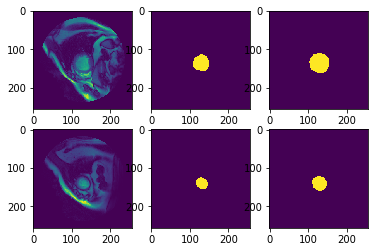

In [0]:
i = 0
print("     Image         I-Contour      O-Contour")
for index, row in combined_frame[:2].iterrows():
  plt.subplot(2,3,i*3+1)
  plt.imshow(row.dicom_image)
  plt.subplot(2,3,i*3+2)
  plt.imshow(row.contour_image_i)
  plt.subplot(2,3,i*3+3)
  plt.imshow(row.contour_image_o)
  i += 1

## Heuristic Approach
Using the pixel difference between heart muscle and blood pool to segment out blood pool

### Generating Threshold

This is an naive implementation that does not normalize the pixel values.

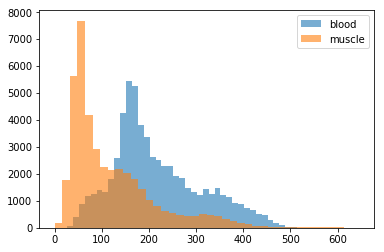

In [0]:
all_blood_pixels = np.array([])
all_muscle_pixels = np.array([])
for _, row in combined_frame.iterrows():
  blood_pixels = row.dicom_image[row.contour_image_i]
  all_blood_pixels = np.concatenate((all_blood_pixels, blood_pixels))
  muscle_pixels = row.dicom_image[np.logical_xor(
      row.contour_image_i, row.contour_image_o)]
  all_muscle_pixels = np.concatenate((all_muscle_pixels, muscle_pixels))
plt.hist(all_blood_pixels, bins=40, alpha=.6,label="blood")
plt.hist(all_muscle_pixels, bins = 40,alpha=.6,label="muscle")
plt.legend(loc='upper right')

Repeat of the procedure above, but normalizing the blood pool and muscle pixels first by subtracting the mean pixel of the entire left ventricle and dividing by the standard deviation of the left ventricle. Here, I only normalize with respect to the ventricle and not the entire image, because we are only looking at pixels within the left ventricle. Normalization reduces variance of MRI images between different patients and possible MRI settings.

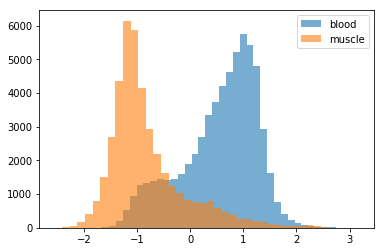

In [0]:
def normalize(x, mean, std):
  return (x - mean) / std

all_blood_pixels = np.array([])
all_muscle_pixels = np.array([])
for _, row in combined_frame.iterrows():
  entire_ventricle_mean = row.dicom_image[row.contour_image_o].mean()
  entire_ventricle_std = row.dicom_image[row.contour_image_o].std()
  
  blood_pixels = normalize(row.dicom_image[row.contour_image_i], 
                           entire_ventricle_mean,
                           entire_ventricle_std)
  all_blood_pixels = np.concatenate((all_blood_pixels, blood_pixels))
  muscle_pixels = normalize(row.dicom_image[np.logical_xor(
      row.contour_image_i, row.contour_image_o)],
                            entire_ventricle_mean,
                            entire_ventricle_std)
  all_muscle_pixels = np.concatenate((all_muscle_pixels, muscle_pixels))
  
plt.hist(all_blood_pixels, bins=40, alpha=.6,label="blood")
plt.hist(all_muscle_pixels, bins = 40,alpha=.6,label="muscle")
plt.legend(loc='upper right')

After normalizing, we do see that the distribution of pixels is pretty bimodal which shows that a thresholding method can work here. There is an overlap, which means the i-contour won't be reconstructed perfectly. However, we can still measure how well a thresholding method will do.

To calculate a good threshold, I use [Otsu's method ](https://en.wikipedia.org/wiki/Otsu%27s_method) over the entire set of pixels.

In [0]:
threshold = skimage.filters.threshold_otsu(
    np.concatenate((all_blood_pixels, all_muscle_pixels)))
print("Using a threshold of %f" % (threshold))

Using a threshold of -0.056785


### Evaluation

For each image, we can use intersection over union (iou) as a measure of how well we can identify the blood pool. The mean intersection over union (miou) over the dataset can give a good measure of how well the segmentation method is doing. Below I calculate the MIOU over the entire dataset.

For predicting the blood pool, I take the *normalized* pixel values greater than the threshold calculated above and make sure the pixels are all within o-contour.

In [0]:
def iou(predicted_mask, ground_truth_mask):
  """Calculates the iou given the prediction and ground truth.

  :param predicted_mask: boolean array of the predicted values.
  :param ground_truth_mask: boolean array of the ground truth values.
  """
  union = np.logical_or(predicted_mask, ground_truth_mask).sum()
  intersection = np.logical_and(predicted_mask, ground_truth_mask).sum()  
  return float(intersection)/ union

def get_prediction_mask(dataframe_row, threshold):
  """Calculates the prediction mask based on threshold

  :param dataframe_row: a dataframe role containing the contour_image_o and 
                        dicom image.
  :param threshold: the min threshold for predicted values.
  """
  entire_ventricle_mean = dataframe_row.dicom_image[row.contour_image_o].mean()
  entire_ventricle_std = dataframe_row.dicom_image[row.contour_image_o].std()
  normalized_dicom_image = normalize(dataframe_row.dicom_image,
                                     entire_ventricle_mean,
                                     entire_ventricle_std) 
  
  # The prediction should only be inside the left ventricle
  prediction_mask = np.logical_and(
      dataframe_row.contour_image_o, 
      normalized_dicom_image > threshold) 
  return prediction_mask

In [0]:
all_iou = np.array([])
all_predictions = []
for index, row in combined_frame.iterrows():
  prediction_mask = get_prediction_mask(row, threshold)
  all_predictions.append(prediction_mask)
  all_iou = np.concatenate((all_iou, [iou(prediction_mask, row.contour_image_i)]))
all_predictions = np.stack(all_predictions) 
print("MIOU: %f" % (all_iou.mean())) 

MIOU: 0.707408


MIOU is actually better than expected, below I examine examples with the best/worst IOU values.

#### Best IOU Examples

     Image    Predicted   Actual  O-Contour


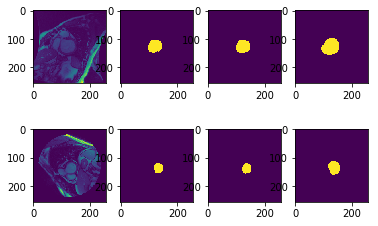

In [0]:
sorted_min_index = np.argsort(all_iou)
print("     Image    Predicted   Actual  O-Contour")
for i in range(2):
  index = sorted_min_index[-1 * i - 1]
  prediction_mask = all_predictions[index]
  dicom_id = combined_frame.index[index]
  gt = combined_frame.contour_image_i[dicom_id]
  gt_image = combined_frame.dicom_image[dicom_id]
  gt_o_image = combined_frame.contour_image_o[dicom_id]
  plt.subplot(2,4,i*4+1)
  plt.imshow(gt_image)  
  plt.subplot(2,4,i*4+2)
  plt.imshow(prediction_mask)  
  plt.subplot(2,4,i*4+3)
  plt.imshow(gt)  
  plt.subplot(2,4,i*4+4)
  plt.imshow(gt_o_image)  

#### Worst IOU Examples

     Image    Predicted   Actual  O-Contour


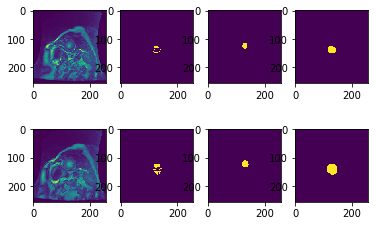

In [0]:
sorted_min_index = np.argsort(all_iou)
print("     Image    Predicted   Actual  O-Contour")
for i in range(2):
  index = sorted_min_index[i]
  prediction_mask = all_predictions[index]
  dicom_id = combined_frame.index[index]
  gt = combined_frame.contour_image_i[dicom_id]
  gt_image = combined_frame.dicom_image[dicom_id]
  gt_o_image = combined_frame.contour_image_o[dicom_id]
  plt.subplot(2,4,i*4+1)
  plt.imshow(gt_image)  
  plt.subplot(2,4,i*4+2)
  plt.imshow(prediction_mask)  
  plt.subplot(2,4,i*4+3)
  plt.imshow(gt)  
  plt.subplot(2,4,i*4+4)
  plt.imshow(gt_o_image)  

## Heuristic Improvement

### Gap Filling - Region Growing

In thresholding, there might be gaps in the blood pool. If a pixel is not classified as part of the blood pool, but the pixels around it are, we can assume it is also part of the blood pool. Here I implement a post processing step for each prediction map where these gaps are filled in based on neighbor heuristics. 

In [0]:
def count_neighbor(mask, i, j):
  """Counts the number of True neighbors at index i, j."""
  
  # Don't worry too much about the boundary case as most blood pools are not
  # on the edges.
  return np.sum(mask[i-1:i+2, j-1:j+2])

def fill_gap(prediction_mask, num_turns, min_neighbors):
    """Modifies the prediction_mask by filling in the gaps.

    In each turn of gap filling, if a non-blood pixel has at least min_neighbors
    blood pixel, it is converted to a blood pixel. Performs this num_turns times.
    
    :param prediction_mask: the mask to fill in.
    :param num_turns: the number of turns to fill in gaps.
    :min_neighbors: the number of neighbors required to be True
    """
    for turn in range(num_turns):
      new_prediction_mask = np.zeros_like(prediction_mask).astype(bool) 
      for i in range(prediction_mask.shape[0]):
        for j in range(prediction_mask.shape[1]):
          if prediction_mask[i][j]:
            new_prediction_mask[i][j] = True
            continue
          if count_neighbor(prediction_mask, i, j) >= min_neighbors:
            new_prediction_mask[i][j] = True
      prediction_mask[:] = new_prediction_mask[:]

In [0]:
all_iou = np.array([])
unchanged_predictions = []
filled_in_predictions = []
for index, row in combined_frame.iterrows():
  prediction_mask = get_prediction_mask(row, threshold)
  unchanged_predictions.append(np.copy(prediction_mask))
  fill_gap(prediction_mask, num_turns=50, min_neighbors=5)
  filled_in_predictions.append(prediction_mask)
  all_iou = np.concatenate((all_iou, [iou(prediction_mask, row.contour_image_i)]))
print("MIOU: %f" % (all_iou.mean())) 

MIOU: 0.720544


Resulting MIOU is 0.720544 which is improved from before. 

         Unfilled             Filled


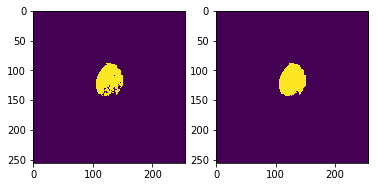

In [0]:
print("         Unfilled             Filled")
plt.subplot(1,2,1)
plt.imshow(unchanged_predictions[14])  
plt.subplot(1,2,2)
plt.imshow(filled_in_predictions[14]) 

### Circle Detection

Heuristic methods for detecting circles might help better locate the blood pool. Most blood pool in the image are circular. We can use [Hough Transform](https://en.wikipedia.org/wiki/Circle_Hough_Transform) to locate possible circles.

These circles can then be used to tune the results from the initial threshold heuristic. For instance, these circles can be used to fill possible gaps in the threshold method. For each circle detected and the center of the circle is within threshold predicted mask, we can mark pixels around the center of that circle as also true. The code for detecting circle is copied from [scikit tutorial](https://scikit-image.org/docs/dev/auto_examples/edges/plot_circular_elliptical_hough_transform.html)

In [0]:
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter, circle
from skimage.util import img_as_ubyte

def detect_circles(input_image, num_circles):
  """Returns (cx, cy, radii) of detected circles"""
  image = img_as_ubyte(input_image / input_image.max())
  edges = canny(image, sigma=3, low_threshold=10, high_threshold=50)

  # Detect two radii
  hough_radii = np.arange(20, 35, 2)
  hough_res = hough_circle(edges, hough_radii)

  accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                             total_num_peaks=num_circles)
  return zip(cx, cy, radii)

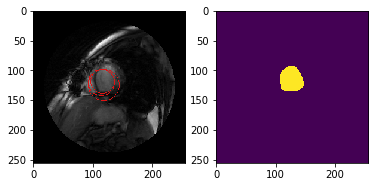

In [0]:
sample_image = combined_frame.iloc[[10]].dicom_image.values[0]

# Show circle on sample image 
plt.subplot(1,2,1)
image = img_as_ubyte(sample_image / sample_image.max())
image = color.gray2rgb(image)
for center_y, center_x, radius in detect_circles(sample_image, 3):
    circy, circx = circle_perimeter(center_y, center_x, radius)
    image[circy, circx] = (220, 20, 20)

plt.imshow(image, cmap=plt.cm.gray)

plt.subplot(1,2,2)
plt.imshow(combined_frame.iloc[[10]].contour_image_i.values[0])


In [0]:
all_iou = np.array([])
for index, row in combined_frame.iterrows():
  prediction_mask = get_prediction_mask(row, threshold)
  circles = detect_circles(row.dicom_image, 5)
  for center_y, center_x, radius in circles:
    
    # If the detected circle center is already marked true, then mark a small
    # circle around the detected center as also true.
    if prediction_mask[center_y][center_x]:
      prediction_mask[circle(center_y, center_x, .3 * radius)] = True
  
  all_iou = np.concatenate((all_iou, [iou(prediction_mask, row.contour_image_i)]))
print("MIOU: %f" % (all_iou.mean())) 

MIOU: 0.712098


We see that adding circle detection improves the MIOU slightly from the original thresholding. Circle detection here is used as another form of gap filling. I can probably squeeze some more performance out if I tune the circle detector to be more sensitive. Also instead of detecting circles, I can detect ellipses.

### Better Data Sanitizing
Looking at the worst IOU examples, I see that there are problematic data points where the i-contour is outside of the o-contour. 

In [0]:
problematic_data = []
for index, row in combined_frame.iterrows():
  blood_pool = np.copy(row.contour_image_i)
  blood_pool[row.contour_image_o] = False 
  if blood_pool.sum() > 0:
    problematic_data.append(index)
print("%d / %d datapoints have i-contour outside of o-contour." % 
      (len(problematic_data), combined_frame.shape[0]))

11 / 46 datapoints have i-contour outside of o-contour.


A large percentage of the dataset has the problem of i-contour outside of o-contour (I'm not exactly sure that this is a problem with the label - maybe there are circumstances where the blood pool might be outside). Either way, if we throw those datapoints out in evaluating the MIOU, we get better results.

In [0]:
all_iou = np.array([])
for index, row in combined_frame.iterrows():
  if index in problematic_data:
    continue
  prediction_mask = get_prediction_mask(row, threshold)
  all_iou = np.concatenate((all_iou, [iou(prediction_mask, row.contour_image_i)]))
print("MIOU: %f" % (all_iou.mean())) 

MIOU: 0.768244


## Conclusion

Using Otsu's method to threshold based on normalized pixel value, we get a MIOU of .72 (on all data, disregarding label inaccuracy). This is pretty good considering how little data we are using and the simplicity of the method. The gap filling heuristic I proposed above can definitely be tuned more to yield even better gains. However, to squeeze out top performance, using deep learning methods is better. I discuss this more in the README.